In [43]:
# IMPORTING LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import plotly.graph_objects as go

In [44]:
# PREPARE DATA

# Load data
df = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

#list(df.columns)

# Convert timestamp from string to datetime

df['datetime_txt'] = df['Date'] + " " + df['Time hh:mm:ss.ddd']
df['datetime'] = pd.to_datetime(df['datetime_txt'], format = '%d/%m/%Y %H:%M:%S.%f')

gps['datetime_txt'] = gps['Date'] + " " + gps['Time']
gps['datetime'] = pd.to_datetime(gps['datetime_txt'], format = '%d/%m/%Y %H:%M:%S')

# Select Columns
df = df[['Acc_x',
        'Acc_y',
        'Acc_z',
        'Mag_x',
        'Mag_y',
        'Mag_z',
        'datetime']]

# Compute 1 second averages
df.set_index('datetime', inplace=True, drop = False)
df = df.resample('1s').mean()
df = df.reset_index(drop=True)
df['datetime'] = df['datetime'].dt.floor('s')

# Row ID column
df['rowID'] = range(0,len(df))

# Calculate elapsed time
df['elapsed_time'] = df['datetime'].diff().apply(lambda x: x.total_seconds())

# Merge GPS and activity data
df = pd.merge(df, gps, on='datetime', how='left')
df.head(10)

,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,rowID,elapsed_time,Date,Time,location.lat,location.long,Height.above.msl,UTM_E,UTM_N,datetime_txt
0,-0.086304,-0.208716,-0.997119,-0.037402,0.071558,-0.270996,2019-02-25 22:24:00,0,NaN,25/02/2019,22:24:00,-26.167846,20.798018,914.0,479814.898495,7.105712e+06,25/02/2019 22:24:00
1,-0.038428,-0.173926,-1.043873,-0.006323,0.064746,-0.272217,2019-02-25 22:24:01,1,1.0,25/02/2019,22:24:01,-26.167847,20.798009,914.0,479813.999248,7.105712e+06,25/02/2019 22:24:01
2,0.041919,-0.208667,-1.012673,0.033252,0.066309,-0.263891,2019-02-25 22:24:02,2,1.0,25/02/2019,22:24:02,-26.167849,20.798000,914.0,479813.100174,7.105712e+06,25/02/2019 22:24:02
3,0.148633,-0.193091,-1.013867,0.047485,0.065674,-0.259741,2019-02-25 22:24:03,3,1.0,25/02/2019,22:24:03,-26.167850,20.797992,914.0,479812.300863,7.105712e+06,25/02/2019 22:24:03
4,0.161817,-0.191895,-1.016260,0.047217,0.066699,-0.260522,2019-02-25 22:24:04,4,1.0,25/02/2019,22:24:04,-26.167851,20.797985,914.0,479811.601487,7.105712e+06,25/02/2019 22:24:04
5,0.178711,-0.188306,-1.021023,0.049585,0.067017,-0.260059,2019-02-25 22:24:05,5,1.0,25/02/2019,22:24:05,-26.167852,20.797981,914.0,479811.201918,7.105712e+06,25/02/2019 22:24:05
6,0.165503,-0.190699,-1.021094,0.049951,0.068335,-0.259229,2019-02-25 22:24:06,6,1.0,25/02/2019,22:24:06,-26.167852,20.797981,914.0,479811.201918,7.105712e+06,25/02/2019 22:24:06
7,0.176319,-0.189502,-1.017479,0.050806,0.068579,-0.257300,2019-02-25 22:24:07,7,1.0,25/02/2019,22:24:07,-26.167851,20.797981,914.0,479811.201746,7.105712e+06,25/02/2019 22:24:07
8,0.188306,-0.185913,-1.022243,0.052832,0.068994,-0.258911,2019-02-25 22:24:08,8,1.0,25/02/2019,22:24:08,-26.167851,20.797981,914.0,479811.201746,7.105712e+06,25/02/2019 22:24:08
9,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,9,1.0,25/02/2019,22:24:09,-26.167851,20.797981,914.0,479811.201746,7.105712e+06,25/02/2019 22:24:09


## STEP 1: COMPUTE ACCELERATION COMPONENTS
Static acceleration is the acceleration component due to the pull of gravity. Following Shepard et al. 2008, static acceleration can be approximated using a moving average. According to Shepard et al. 2008, the length of the running mean should correspond to the point (or follow the point) where calculated overall dynamic body acceleration (ODBA) stabizes. 



/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_26106/1377182390.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Gx'] = res['Acc_x'].rolling(window=win).mean()
/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_26106/1377182390.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Gy'] = res['Acc_y'].rolling(window=win).mean()
/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_26106/1377182390.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

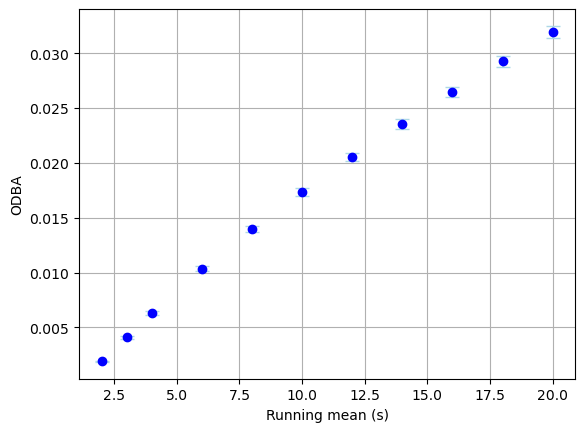

In [45]:
# WINDOW LENGTH SELECTION

# Possible window lengths
windows = [2,3,4,6,8,10,12,14,16,18,20]

# Set up dataframe to store results
acc_data = df[['Acc_x','Acc_y','Acc_z']]
window_results = pd.DataFrame(columns = ['Acc_x','Acc_y','Acc_z','Gx','Gy','Gz','DAx','DAy','DAz','ODBA','WindowLength'])

# Compute static acceleration using possible window lengths
for win in windows:
    # Get raw acceleration and set up results table
    res = acc_data
    # Compute static acceleration using rolling mean
    res['Gx'] = res['Acc_x'].rolling(window=win).mean()
    res['Gy'] = res['Acc_y'].rolling(window=win).mean()
    res['Gz'] = res['Acc_z'].rolling(window=win).mean()
    # Compute dynamic acceleration
    res['DAx'] = res['Acc_x'] - res['Gx']
    res['DAy'] = res['Acc_y'] - res['Gy']
    res['DAz'] = res['Acc_z'] - res['Gz']
    # Compute ODBA
    res['ODBA'] = res['DAx'] ** 2 + res['DAy'] ** 2 + res['DAz'] ** 2
    # Store Results
    res['WindowLength'] = [win]*len(res)
    res.head(10)
    window_results = pd.concat([window_results, res], ignore_index=True)

# Plot results
grouped = window_results.groupby('WindowLength')['ODBA']
means = grouped.mean()
std_errors = grouped.sem()
plt.errorbar(means.index, means, yerr=std_errors, fmt='o', color='blue', ecolor='lightblue', capsize=5)
plt.xlabel('Running mean (s)')
plt.ylabel('ODBA')
plt.grid(True)
plt.show()


    

In [46]:
# CALCULATE STATIC ACCELERATION
w = 10
df['Gx'] = df['Acc_x'].rolling(window=w).mean()
df['Gy'] = df['Acc_y'].rolling(window=w).mean()
df['Gz'] = df['Acc_z'].rolling(window=w).mean()

# Remove rows with NaN static accleration
df = df.iloc[w-1:].reset_index(drop=True)

In [47]:
# CALCULATE DYNAMIC ACCELERATION
df['DAx'] = df['Acc_x']-df['Gx']
df['DAy'] = df['Acc_y']-df['Gy']
df['DAz'] = df['Acc_z']-df['Gz']

In [48]:
# CALCULATE VeDBA
df['VeDBA']= (df['DAx']**2 + df['DAy']**2 + df['DAz']**2)**0.5

## STEP 2: COMPUTE PITCH AND ROLL
- Pitch = rotation about the lateral axis
- Roll = rotation about the anterior-posterior axis
- Yaw (heading) = rotation about the dorso-ventral axis.

In [49]:
# COMPUTE PITCH

# Function to compute roll
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))*180/math.pi
    return(pitch)

# Compute roll
df['pitch']=df.apply(calculate_pitch,axis=1)


In [50]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))*180/math.pi
    return(roll)

# Compute roll
df['roll']=df.apply(calculate_roll,axis=1)

## STEP 3: CORRECT MAGNETOMETER DATA


In [51]:
# Filter for calibration events
# df_cal = df[df['Marked.event']==2]

# Calculate offsetts
# Ox = (df['Mag_x'].max() - df['Mag_x'].min())/2
# Oy = (df['Mag_y'].max() - df['Mag_y'].min())/2
# Oz = (df['Mag_z'].max() - df['Mag_z'].min())/2

# Correct Magnetometer Output
# df['Mx'] = df['Mag_x'] - Ox
# df['My'] = df['Mag_y'] - Oy
# df['Mz'] = df['Mag_z'] - Oz

## STEP 4: NORMALIZE COMPASS DATA

In [52]:
# Function to compute normalization factor
def calc_normalization_factor(row):
    Mx = row['Mag_x']
    My = row['Mag_y']
    Mz = row['Mag_z']
    fm = math.sqrt(Mx**2 + My**2 + Mz**2)
    return fm

# Compute normalization factor
df['fm'] = df.apply(calc_normalization_factor,axis=1)

# Normalize compass data
df['NMx'] = df['Mag_x']/df['fm']
df['NMy'] = df['Mag_y']/df['fm']
df['NMz'] = df['Mag_z']/df['fm']

## STEP 5: ROTATE AXES ACCORDING TO PITCH AND ROLL 

In [53]:
# Function to generate pitch rotation matrix
def get_rx(pitch):
    Rx = np.array([[1,0,0],
          [0,math.cos(pitch),-math.sin(pitch)],
          [0,math.sin(pitch),math.cos(pitch)]])
    return Rx

# Function to generate roll rotation matrix
def get_ry(roll):
    Ry = np.array([[math.cos(roll),0,math.sin(roll)],
         [0,1,0],
         [-math.sin(roll),0,math.cos(roll)]])
    return Ry

# Function to rotate axes
def rotate_axes(row):
    NMx = row['NMx']
    NMy = row['NMy']
    NMz = row['NMz']
    NM = np.array([NMx,NMy,NMz])
    
    pitch = row['pitch']
    Rx = get_rx(pitch = pitch)
    
    roll = row['roll']
    Ry = get_ry(roll = roll)
    
    RNM = np.dot(NM,np.dot(Rx,Ry))

    row['RNMx'] = RNM[0]
    row['RNMy'] = RNM[1]
    return(row)

# Rotate axes of magnetometer output
df['RNMx'] = -999
df['RNMy'] = -999
df = df.apply(rotate_axes,axis=1)
df['pitch']


0         6.138781
1         7.624402
2         8.841972
3         9.664698
4         9.894881
           ...    
75390    10.893161
75391    10.776309
75392    10.617338
75393    10.430807
75394    10.160247
Name: pitch, Length: 75395, dtype: float64

## STEP 5: DERIVE HEADING


In [54]:
# Function to derive heading
def get_heading(row):
    rnmx = row['RNMx']
    rnmy = row['RNMy']
    h = math.atan2(rnmy,-rnmx)*180/math.pi
    return h

def get_raw_heading(row):
    nmx = row['NMx']
    nmy = row['NMy']
    h = math.atan2(nmy,-nmx)*180/math.pi
    return h

# Calculate heading
df['H'] = df.apply(get_heading,axis = 1)
df['H_raw'] = df.apply(get_raw_heading,axis=1)

## STEP 6: CALCULATE SPEED FROM VEDBA

In [55]:
# Initialize constants with nominal values
# These will be changed later on when aligning dead-reckoned trajectories with GPS

m = 1 # constant of proportionality
c = 0.01 # constant

# Calculate speed (speed = (m*VeDBA)+c
df['s'] = m*df['VeDBA'] + c

# Calculate distance (distance = speed * time)
df['d'] = df['s'] * df['elapsed_time']
df.head(10)


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,rowID,elapsed_time,Date,...,fm,NMx,NMy,NMz,RNMx,RNMy,H,H_raw,s,d
0,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,9,1.0,25/02/2019,...,0.273992,0.202447,0.246999,-0.947632,0.070507,0.380795,100.489937,129.338898,0.077368,0.077368
1,0.189478,-0.189502,-1.023487,0.057129,0.067090,-0.258252,2019-02-25 22:24:10,10,1.0,25/02/2019,...,0.272872,0.209362,0.245866,-0.946424,0.490502,-0.865640,-119.537428,130.415332,0.060423,0.060423
2,0.182300,-0.188306,-1.010278,0.062183,0.065405,-0.257812,2019-02-25 22:24:11,11,1.0,25/02/2019,...,0.273152,0.227649,0.239447,-0.943844,-0.551249,-0.719382,-52.537708,133.553106,0.032824,0.032824
3,0.194287,-0.184717,-1.015016,0.077222,0.057056,-0.253369,2019-02-25 22:24:12,12,1.0,25/02/2019,...,0.270951,0.285002,0.210575,-0.935111,-0.049108,0.017661,19.780606,143.540960,0.028788,0.028788
4,0.189502,-0.195484,-1.001856,0.079932,0.054590,-0.251123,2019-02-25 22:24:13,13,1.0,25/02/2019,...,0.269132,0.296998,0.202837,-0.933086,0.153657,0.241834,122.431124,145.668615,0.028747,0.028747
5,0.190699,-0.196680,-1.006617,0.081909,0.053735,-0.250024,2019-02-25 22:24:14,14,1.0,25/02/2019,...,0.268531,0.305027,0.200109,-0.931083,0.268457,0.389825,124.553585,146.733685,0.023771,0.023771
6,0.200269,-0.199072,-1.016284,0.084253,0.052563,-0.249024,2019-02-25 22:24:15,15,1.0,25/02/2019,...,0.268094,0.314267,0.196064,-0.928868,0.325265,0.491140,123.515157,148.040908,0.026719,0.026719
7,0.196680,-0.201489,-1.009032,0.085132,0.052539,-0.249072,2019-02-25 22:24:16,16,1.0,25/02/2019,...,0.268412,0.317169,0.195741,-0.927949,0.380654,0.625965,121.304097,148.319220,0.023428,0.023428
8,0.202661,-0.199072,-1.006665,0.083789,0.052344,-0.248804,2019-02-25 22:24:17,17,1.0,25/02/2019,...,0.267701,0.312995,0.195531,-0.929409,0.391000,0.726889,118.276177,148.006626,0.024498,0.024498
9,0.205053,-0.196680,-1.012647,0.082886,0.054736,-0.251929,2019-02-25 22:24:18,18,1.0,25/02/2019,...,0.270803,0.306074,0.202126,-0.930303,0.384733,0.781136,116.221634,146.559907,0.022322,0.022322


## STEP 7: PERFORM DEAD RECKONING CALCULATION

In [58]:
# Compute speed coefficient (q; used to overcome cartesian grid errors)
# q = d/R
# R = radius of the Earth = 6.371e6

df['q'] = df['d']/6.371e6

# Function to perform dead-reckoning
def the_reckoning(row):

    global prev_row 
    
    if prev_row is None:
        
        row['DR_lat'] = row['location.lat']
        row['DR_lon'] = row['location.long']
        
    else:
        # Setting up variables
        Lat0 = prev_row['DR_lat']
        Lon0 = prev_row['DR_lon']
        print(Lat0)
        print(Lon0)
        q = row['q']
        H = row['H']
        sinLat0 = math.sin(Lat0)
        cosq = math.cos(q)
        cosLat0 = math.cos(Lat0)
        sinq = math.cos(q)
        cosH = math.cos(H)
        sinH = math.sin(H)
        sinq = math.sin(q)
        cosLat0 = math.cos(Lat0)
        cosq = math.cos(q)
        sinLat0 = math.sin(Lat0)
        
        # Dead reckoning calculation
        Lat = math.asin(sinLat0*cosq + cosLat0*sinq*cosH)
        print(Lat)
        sinLati = math.sin(Lat)
        Lon = Lon0 + math.atan2((sinH*sinq*cosLat0),(cosq-sinLat0*sinLati))
        print(Lon)

        # Return result
        row['DR_lat'] = Lat
        row['DR_lon'] = Lon
        
    prev_row = row
    
    return row
    

# Perform dead reckoning
prev_row = None
df['DR_lat'] = -999
df['DR_lon'] = -999
df = df[df['location.lat'] != 0].iloc[:10]
for index, row in df.iterrows():
    df.loc[index] = the_reckoning(row)
        

-26.167851
20.797981
-1.0351097619141325
20.79798099709654
-1.0351097619141325
20.79798099709654
-1.0351097652388586
20.79798098938576
-1.0351097652388586
20.79798098938576
-1.0351097625413124
20.7979809964876
-1.0351097625413124
20.7979809964876
-1.0351097670348153
20.797980997290832
-1.0351097670348153
20.797980997290832
-1.0351097653761023
20.797980990742985
-1.0351097653761023
20.797980990742985
-1.0351097676665453
20.797980983860267
-1.0351097676665453
20.797980983860267
-1.035109768937087
20.79798099062093
-1.035109768937087
20.79798099062093
-1.0351097672078031
20.797980983892398
-1.0351097672078031
20.797980983892398
-1.0351097707109065
20.7979809840111


/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_26106/105273752.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-26.167851' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index] = the_reckoning(row)
/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_26106/105273752.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.797981' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index] = the_reckoning(row)


In [ ]:
sample_res = df[['GPS.Latitude','DR_lat','GPS.Longitude','DR_lon']]
sample_res.head(20)